In [20]:
import sys
import os
from pathlib import Path
import pandas as pd
import sys


import os
from pathlib import Path
parent_dir = os.path.dirname(os.getcwd())
sys.path.append(parent_dir)
processed_series_path = Path(parent_dir) / 'processed_series'
generated_series_path = Path(parent_dir) / 'generated_series'
figure_save_path = Path(parent_dir) / 'figures'
if not figure_save_path.exists():
    os.makedirs(figure_save_path)

import copy
from scipy.special import erf
from scipy.stats import norm
import numpy as np
import matplotlib.pyplot as plt
import pickle
from models.ICL import MultiResolutionPDF
import sys
import torch
sys.path.append("../models")

def Markov_BT_loss(series_dict, temperature = 1):
    logit_mat_good = series_dict['logit_mat_good']
    probs = torch.nn.functional.softmax(logit_mat_good / temperature, dim=-1)
    P = series_dict['P']
    full_array = series_dict['full_array']
    N_state = P.shape[0]
    states = np.arange(N_state)
    start_idx = 0
    loss_array = np.zeros(full_array[start_idx:].squeeze().shape)
    for state in states:
        ### add 2 to slice out BOS
        pos = np.where(full_array[start_idx:]==state)[0]+2
        learned_p_out = probs.squeeze()[start_idx:][pos]
        true_p_out = torch.tensor(P[state])
        ### Bhattacharyya distance at each row
        sqrt_PQ = torch.sum(torch.sqrt(learned_p_out * true_p_out), dim = 1)
        BH_dist = -torch.log(sqrt_PQ)
        dist = BH_dist
        loss_array[pos-2] = dist.numpy()
        
    window_size = 20
    top_hat_kernel = np.ones(window_size) / window_size
    averaged_loss = np.convolve(loss_array, top_hat_kernel, mode='valid')
    x_range = np.arange(window_size//2, len(loss_array) - window_size//2 + 1)
    return x_range, averaged_loss
    
def loss_with_true_PDF(processed_dict, temperature, loss_func = "BT"):
    loss_list = []
    PDF_list = processed_dict['PDF_list']
    true_PDF = processed_dict['true_PDF']
    for PDF in PDF_list:
        if temperature != 1:
            PDF.rescale_temperature(temperature)
    for PDF in PDF_list:
        if loss_func == "BT_dist":
            loss = PDF.BT_dist(true_PDF)
        elif loss_func == "Hel_dist":
            loss = PDF.Hel_dist(true_PDF)
        elif loss_func == "L2_dist":
            loss = PDF.L2_dist(true_PDF)
        loss_list.append(loss)
    loss_arr = np.array(loss_list)
    window_size = 4
    top_hat_kernel = np.ones(window_size) / window_size
    kernel = top_hat_kernel        
    averaged_loss = np.convolve(loss_arr, kernel, mode='valid')
    x_range = np.arange(window_size//2, len(loss_arr) - window_size//2 + 1)
    return(x_range, averaged_loss)

def experiment_plotter(series_name, xlog, ylog, processed_series, legend = False, temperature = 1, loss_func = "BT_dist"):
    BT_loss_list = []
    mean_loss_list = []
    avg_mean_loss = None
    avg_BT_loss = None

    fig, ax1 = plt.subplots(figsize=(8, 3))
    axs = [ax1]

    if xlog:
        for ax in axs:
            ax.set_xscale('log')
        
    if ylog:
        for ax in axs:
            ax.set_yscale('log')    
    
    for series_dict in processed_series[series_name]:
        if series_dict['true_PDF'] is not None:
            x_range, indiv_loss = loss_with_true_PDF(series_dict, temperature = temperature, loss_func = loss_func)
            BT_loss = indiv_loss
        else:
            raise NotImplementedError("Only series with true_PDF is supported.")
        
        BT_loss_list += [BT_loss]
                         
        
        ax1.plot(x_range, BT_loss, linewidth=2, c='black', alpha = 0.1)

        
    avg_BT_loss = np.mean(BT_loss_list, axis=0)
    
    if legend:
        if series_name not in ['markov_chain_70b', 'markov_chain_13b']:
            ax1.plot(x_range, avg_BT_loss , linewidth=2, c='black', alpha = 0.7, label = "average loss")
    else:
        ax1.plot(x_range, avg_BT_loss , linewidth=2, c='black', alpha = 0.7)

        
    ax1.set_ylabel("Loss")
    ax1.set_xlabel("context length")

    ax1.grid(True, which='both', linestyle='--', linewidth=0.5)
    print(f"number of trajectories: {len(BT_loss_list)}")
    if legend:
        ax1.legend(loc='upper right')

    return x_range, avg_BT_loss

In [35]:
### load all series
processed_series_files = sorted([path for path in processed_series_path.iterdir()], key=lambda x: x.name)
generated_series_files = sorted([path for path in generated_series_path.iterdir()], key=lambda x: x.name)
  
all_series = {}
processed_series = {}
for idx, file in enumerate(generated_series_files):
    series_name = file.name.rsplit('_', 1)[0]
    if series_name not in all_series:
        all_series[series_name] = []
        processed_series[series_name] = []
    series_dict = pickle.load(file.open('rb'))
    series_dict['series_name'] = file.name[:-4]
    corresponding_processed_file = next((processed_file for processed_file in processed_series_files if processed_file.name == file.name), None)
    if corresponding_processed_file is not None:
        processed_dict = pickle.load(corresponding_processed_file.open('rb'))
        series_dict['processed?'] = "yes" 
        # print(series_dict['series_name'])
        # print(processed_dict.keys())
        # break
        processed_dict["series_name"] = file.name[:-4]
        processed_series[series_name] += [processed_dict]
    else:
        series_dict['processed?'] = 'no'
    all_series[series_name] += [series_dict]
    

# Create a DataFrame to store the series data
series_df = pd.DataFrame(columns=['Name', 'Random Seed', 'Precision', 'Mode', 'refine_depth', '# states', 'llama_size', 'processed?'])

for key, series_list in all_series.items():
    if key == 'markov_chain':
        for series in series_list:
            # Append the series data to the DataFrame
            new_row = pd.DataFrame({'Name': [series['series_name']], 
                                    'Random Seed': [series['random_seed']], 
                                    'Precision': ["NA"], 
                                    'Mode': ["NA"],
                                    'refine_depth': ["NA"],
                                    '# states': [series['P'].shape[0]],
                                    'llama_size': [series['llama_size']],
                                    'processed?': [series['processed?']]})
            # Explicitly cast to bool dtype to avoid FutureWarning
            series_df = pd.concat([series_df, new_row], ignore_index=True)
    else:
        for series in series_list:
            # Append the series data to the DataFrame
            new_row = pd.DataFrame({'Name': [series['series_name']], 
                                    'Random Seed': [series['random_seed']], 
                                    'Precision': [series['prec']], 
                                    'Mode': [series['mode']],
                                    'refine_depth': [series['refine_depth']],
                                    '# states': ['NA'],
                                    'llama_size': [series['llama_size']],
                                    'processed?': [series['processed?']]})
            # Explicitly cast to bool dtype to avoid FutureWarning
            series_df = pd.concat([series_df, new_row], ignore_index=True)

# Print the DataFrame without the index
print(series_df.to_string(index=True))

processed_series_for_appendix = processed_series.copy()


                                                     Name Random Seed Precision Mode refine_depth # states llama_size processed?
0              uncorrelated_gaussian_centered_sigma_0.1_0           2         2  all            1       NA        13b        yes
1              uncorrelated_gaussian_centered_sigma_0.1_1           3         2  all            1       NA        13b        yes
2              uncorrelated_gaussian_centered_sigma_0.1_2           2         2  all            1       NA         7b        yes
3              uncorrelated_gaussian_centered_sigma_0.1_3           3         2  all            1       NA         7b        yes
4              uncorrelated_gaussian_centered_sigma_0.1_4           2         2  all            1       NA        70b        yes
5              uncorrelated_gaussian_centered_sigma_0.1_5           3         2  all            1       NA        70b        yes
6          uncorrelated_gaussian_centered_sigma_0.1_KDE_0           2         2  all            1

In [36]:
processed_series.keys()

dict_keys(['uncorrelated_gaussian_centered_sigma_0.1', 'uncorrelated_gaussian_centered_sigma_0.1_KDE', 'uncorrelated_gaussian_centered_sigma_0.1_histogram', 'uncorrelated_gaussian_centered_sigma_0.3', 'uncorrelated_gaussian_centered_sigma_0.3_KDE', 'uncorrelated_gaussian_centered_sigma_0.3_histogram', 'uncorrelated_gaussian_centered_sigma_0.5', 'uncorrelated_gaussian_centered_sigma_0.5_KDE', 'uncorrelated_gaussian_centered_sigma_0.5_histogram', 'uncorrelated_gaussian_centered_sigma_0.8', 'uncorrelated_gaussian_centered_sigma_0.8_KDE', 'uncorrelated_gaussian_centered_sigma_0.8_histogram', 'uncorrelated_random_PDF_l_0.02_KDE', 'uncorrelated_random_PDF_l_0.1_13b', 'uncorrelated_random_PDF_l_0.1_70b', 'uncorrelated_random_PDF_l_0.1_7b', 'uncorrelated_random_PDF_l_0.1_KDE', 'uncorrelated_random_PDF_l_0.1_histogram', 'uncorrelated_random_PDF_l_0.4_70b', 'uncorrelated_random_PDF_l_0.4_KDE', 'uncorrelated_random_PDF_l_0.4_histogram', 'uncorrelated_uniform_centered_sigma_0.1', 'uncorrelated_uni

In [37]:
processed_series['uncorrelated_random_PDF_l_0.1_70b'][0]['true_PDF']

In [38]:
### Choose type of trajectories to keep

for series_type, series_list in processed_series.items():
    if series_type == 'geometric_brownian_motion':
        processed_series[series_type] = [series_dict for series_dict in series_list if series_dict['prec'] == 3]
    
fig_1_series = {}

### Plots for appendix

In [39]:
loss_func = "L2_dist"
loss_func = "BT_dist"
loss_func = "Hel_dist"

number of trajectories: 4


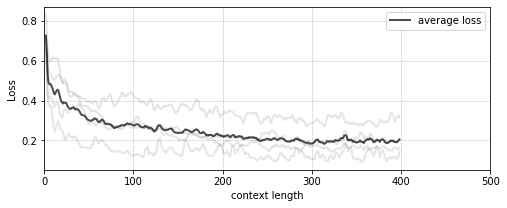

In [40]:
series_name = 'uncorrelated_random_PDF_l_0.1_70b'
x_range, avg_loss = experiment_plotter(series_name = series_name,
                   xlog = 0, 
                   ylog = 0, 
                   processed_series=processed_series_for_appendix, legend = True, loss_func = loss_func)

fig_1_series[series_name] = (x_range[:1000], avg_loss[:1000])
plt.gca().set_xlim(0,500)
plt.savefig(figure_save_path / f"{series_name}.png", dpi=300, bbox_inches='tight')
plt.show()

number of trajectories: 2


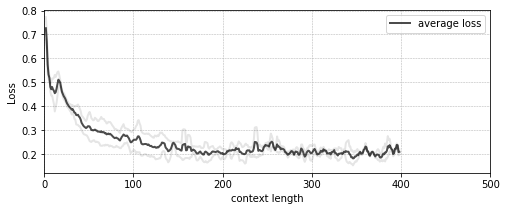

In [41]:
series_name = 'uncorrelated_random_PDF_l_0.1_13b'
x_range, avg_loss = experiment_plotter(series_name = series_name,
                   xlog = 0, 
                   ylog = 0, 
                   processed_series=processed_series_for_appendix, legend = True, loss_func = loss_func)

fig_1_series[series_name] = (x_range[:1000], avg_loss[:1000])
plt.gca().set_xlim(0,500)
plt.savefig(figure_save_path / f"{series_name}.png", dpi=300, bbox_inches='tight')
plt.show()

number of trajectories: 2


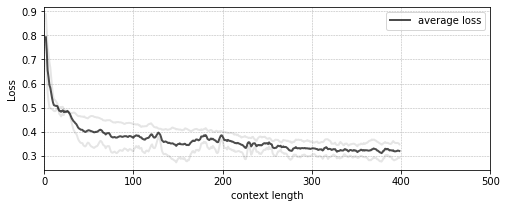

In [42]:
series_name = 'uncorrelated_random_PDF_l_0.1_7b'
x_range, avg_loss = experiment_plotter(series_name = series_name,
                   xlog = 0, 
                   ylog = 0, 
                   processed_series=processed_series_for_appendix, legend = True, loss_func = loss_func)

fig_1_series[series_name] = (x_range[:1000], avg_loss[:1000])
plt.gca().set_xlim(0,500)
plt.savefig(figure_save_path / f"{series_name}.png", dpi=300, bbox_inches='tight')
plt.show()

number of trajectories: 5


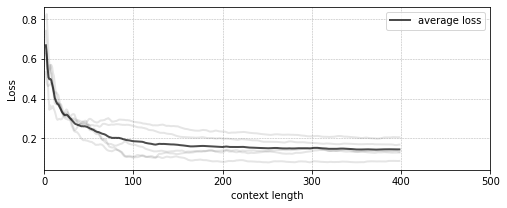

In [43]:
series_name = 'uncorrelated_random_PDF_l_0.1_KDE'
x_range, avg_loss = experiment_plotter(series_name = series_name,
                   xlog = 0, 
                   ylog = 0, 
                   processed_series=processed_series_for_appendix, legend = True, loss_func = loss_func)

fig_1_series[series_name] = (x_range[:1000], avg_loss[:1000])
plt.gca().set_xlim(0,500)
plt.savefig(figure_save_path / f"{series_name}.png", dpi=300, bbox_inches='tight')
plt.show()

number of trajectories: 4


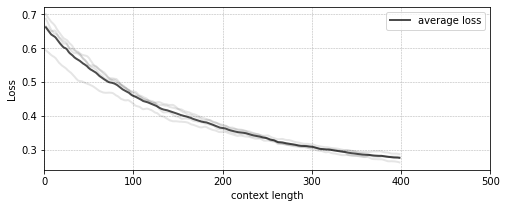

In [44]:
series_name = 'uncorrelated_random_PDF_l_0.1_histogram'
x_range, avg_loss = experiment_plotter(series_name = series_name,
                   xlog = 0, 
                   ylog = 0, 
                   processed_series=processed_series_for_appendix, legend = True, loss_func = loss_func)

fig_1_series[series_name] = (x_range[:1000], avg_loss[:1000])
plt.gca().set_xlim(0,500)
plt.savefig(figure_save_path / f"{series_name}.png", dpi=300, bbox_inches='tight')
plt.show()

### Master Plot

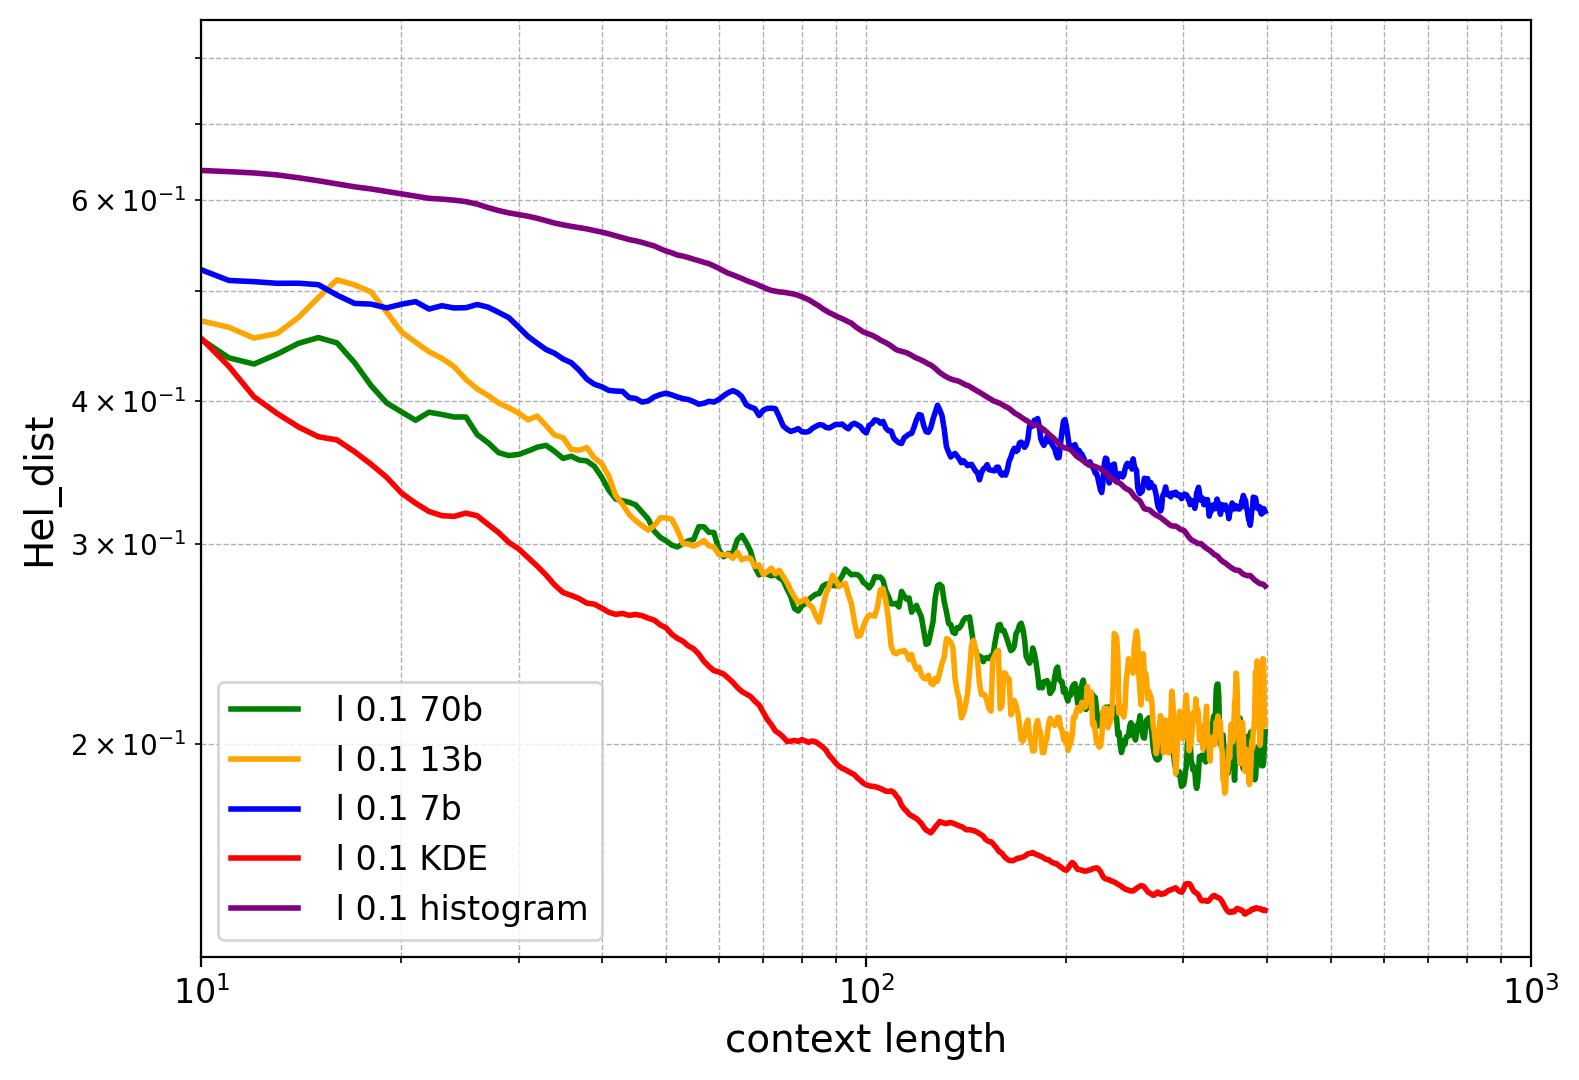

In [50]:
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import seaborn as sns

# Define line styles for different series
line_styles = ['solid'] * 4
ordered_series_names = ['uncorrelated_random_PDF_l_0.1_70b', 'uncorrelated_random_PDF_l_0.1_13b', 'uncorrelated_random_PDF_l_0.1_7b', 'uncorrelated_random_PDF_l_0.1_KDE', 'uncorrelated_random_PDF_l_0.1_histogram']
colors = [ 'green', 'orange', 'blue', 'red', 'purple']

fig, ax1 = plt.subplots(figsize=(8, 5.5), dpi = 200)

for i, series_name in enumerate(ordered_series_names):
    x, y = fig_1_series[series_name]
    if line_styles[i % len(line_styles)] == 'solid':
        ax1.plot(x, y, linewidth=2, label=series_name[23:].replace('_', ' '), linestyle=line_styles[i % len(line_styles)], color=colors[i], alpha = 1)
    else:
        ax2.plot(x, y, linewidth=2, label=series_name[23:].replace('_', ' '), linestyle=line_styles[i % len(line_styles)], color=colors[i], alpha = 1)

ax1.set_xscale('log')
ax1.set_yscale('log')

# Set grid lines
ax1.grid(True, which='both', linestyle='--', linewidth=0.5)

# Set labels with larger font size
ax1.set_xlabel("context length", fontsize=14)
ax1.set_ylabel(loss_func, fontsize=14)

# Set legend inside the plot area
legend1 = ax1.legend(loc='lower left', fontsize=12)


# Increase tick label size
ax1.tick_params(axis='both', which='major', labelsize=12)

ax1.set_xlim(10,1000)
# Use tight layout
plt.tight_layout()

# Save the figure in high resolution
plt.savefig(figure_save_path / "fig1.png", dpi=300, bbox_inches='tight')

plt.show()

### Neural Scaling Law

In [53]:
# Define line styles for different series
line_styles = ['solid'] * 4
ordered_series_names = ['uncorrelated_random_PDF_l_0.1_70b', 'uncorrelated_random_PDF_l_0.1_13b', 'uncorrelated_random_PDF_l_0.1_7b', 'uncorrelated_random_PDF_l_0.1_KDE', 'uncorrelated_random_PDF_l_0.1_histogram']
colors = [ 'green', 'orange', 'blue', 'red', 'purple']

from scipy.optimize import curve_fit

# Define the power-law function
def power_law(x, d_c, alpha):
    return x** alpha / d_c

# Initialize a dictionary to store the fitted lines
fitted_lines = {}
fitted_alphas = {}

# Loop over each series
for i, series_name in enumerate(ordered_series_names):
    x, y = fig_1_series[series_name]
    
    # Fit the power-law function to the data
    # if series_name in ['brownian_motion', 'geometric_brownian_motion']:
    if series_name is None:
        popt, pcov = curve_fit(power_law, x[:400], y[:400], maxfev=1000,p0 = np.asarray([5,-1]))
    else:
        popt, pcov = curve_fit(power_law, x, y, maxfev=1000,p0 = np.asarray([5,-1]))
    print(series_name)
    print(popt)
    print(pcov)
    # Generate the fitted line
    fitted_line = power_law(x, *popt)
    
    # Store the fitted line in the dictionary
    fitted_lines[series_name] = fitted_line
    fitted_alphas[series_name] = popt[1]

uncorrelated_random_PDF_l_0.1_70b
[ 1.23166166 -0.24186291]
[[8.53675800e-05 1.44676005e-05]
 [1.44676005e-05 2.67960779e-06]]
uncorrelated_random_PDF_l_0.1_13b
[ 1.14430552 -0.25708966]
[[2.22294366e-04 4.08408310e-05]
 [4.08408310e-05 8.24597427e-06]]
uncorrelated_random_PDF_l_0.1_7b
[ 1.32389679 -0.14589555]
[[1.14033087e-04 1.73046956e-05]
 [1.73046956e-05 2.78975724e-06]]
uncorrelated_random_PDF_l_0.1_KDE
[ 1.15052853 -0.31994648]
[[7.81343220e-05 1.47624630e-05]
 [1.47624630e-05 3.14679248e-06]]
uncorrelated_random_PDF_l_0.1_histogram
[ 0.92478047 -0.20510084]
[[2.70002546e-04 5.99770476e-05]
 [5.99770476e-05 1.43845307e-05]]


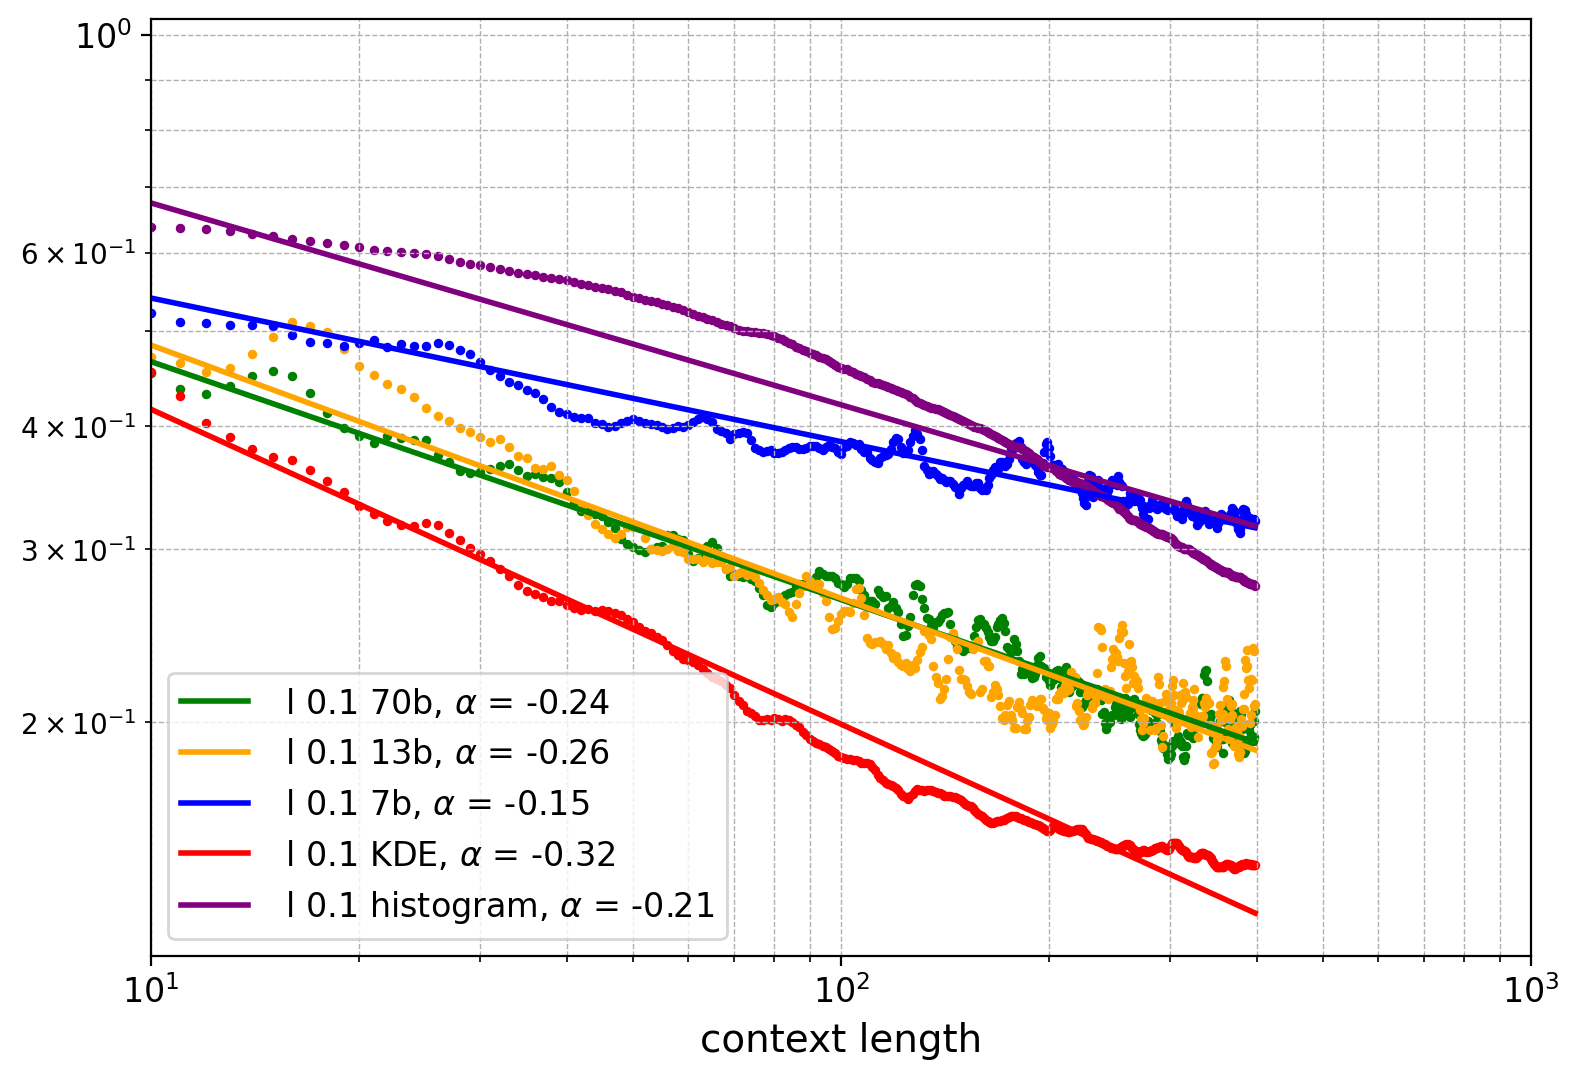

In [54]:
fig, ax1 = plt.subplots(figsize=(8, 5.5), dpi = 200)

for i, series_name in enumerate(ordered_series_names):
    x, y = fig_1_series[series_name]
    y_fit = fitted_lines[series_name]
    alpha = fitted_alphas[series_name]
    label_str = rf"{series_name[23:].replace('_', ' ')}, $\alpha$ = {alpha:.2f}"
    ax1.scatter(x, y, linewidth=2, s=2, linestyle=line_styles[i % len(line_styles)], color=colors[i], alpha = 1)
    ax1.plot(x, y_fit, linewidth=2, label=label_str, linestyle=line_styles[i % len(line_styles)], color=colors[i], alpha = 1)

ax1.set_xscale('log')
ax1.set_yscale('log')

# Set grid lines
ax1.grid(True, which='both', linestyle='--', linewidth=0.5)

# Set labels with larger font size
ax1.set_xlabel("context length", fontsize=14)


# Set legend inside the plot area
legend1 = ax1.legend(loc='lower left', fontsize=12)

# Increase tick label size
ax1.tick_params(axis='both', which='major', labelsize=12)

ax1.set_xlim(10,1000)
# Use tight layout
plt.tight_layout()

# Save the figure in high resolution
plt.savefig(figure_save_path / "ICL_power_law.png", dpi=300, bbox_inches='tight')

plt.show()
